In [39]:
# This notebook takes the input dataset, finds quartiles for the medical interventions (IV in, max vaso in)
# for each block.
# We then discretise actions in the original dataset according to what bin they fall in, and then save 
# a new dataframe with the discretised actions.

In [40]:
%matplotlib inline

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [42]:
orig_data = pd.read_csv("C:/Users/logik/Desktop/rlsepsis234-master - full/data/A002_MyData.csv")

In [43]:
# Do not do that, for the sake of RL training
orig_data['SpO2'] = pd.qcut(orig_data['SpO2'], 4, labels=False, duplicates='drop')
orig_data['Vitl009_SOFA'] = pd.qcut(orig_data['Vitl009_SOFA'], 4, labels=False, duplicates='drop')
orig_data['Temp_C'] = pd.qcut(orig_data['Temp_C'], 4, labels=False, duplicates='drop')
orig_data['GCS'] = pd.qcut(orig_data['GCS'], 4, labels=False, duplicates='drop')

In [44]:
# orig_data.to_csv("../data/MKdataset07Feb17.csv", index=False)

In [45]:
# assume we're using input_4hourly and max_dose_vaso as the input params for now
interventions = orig_data[["Flud003_MaxVaso", "Flud002_Input4H"]]   # input_4hourly_tev originally

In [46]:
interventions.head()

,Flud003_MaxVaso,Flud002_Input4H
0,0.0,20.0
1,0.0,20.0
2,0.0,20.0
3,0.0,20.0
4,0.0,20.0


In [47]:
adjusted_vaso = interventions["Flud003_MaxVaso"][interventions["Flud003_MaxVaso"] >0]
adjusted_iv = interventions["Flud002_Input4H"][interventions["Flud002_Input4H"]>0]  # input_4hourly_tev originally

In [48]:
vaso_quartiles = adjusted_vaso.quantile([0.25,0.50,0.75])
iv_quartiles = adjusted_iv.quantile([0.25,0.5,0.75])

In [49]:
vq = np.array(vaso_quartiles)
vq

array([0.07, 0.2 , 0.36])

In [50]:
ivq = np.array(iv_quartiles)
ivq

array([ 12.5       ,  36.90181667, 125.        ])

In [51]:
# so, for vasopressors:
# 0 = input_0
# 0 < vaso < 0.08 = input_1
# 0.08 <= vaso < .225 = input_2
# .225 <= vaso < .45 = input_3
# .45 <= input_4

In [52]:
# for iv:
# 0 = input_0
# 0 < vaso < 50 = input_1
# 50 <= vaso < .180.435 = input_2
# 180.435 <= vaso < 529.757 = input_3
# 529.757 <= input_4

In [53]:
import copy
discretised_int = copy.deepcopy(interventions)

In [54]:
discretised_int['vaso_input'] = discretised_int['Flud003_MaxVaso']
discretised_int['vaso_input'][interventions['Flud003_MaxVaso'] == 0.0] = 0
discretised_int['vaso_input'][(interventions['Flud003_MaxVaso'] > 0.0) & (interventions['Flud003_MaxVaso'] < vq[0])] = 1
discretised_int['vaso_input'][(interventions['Flud003_MaxVaso'] >= vq[0]) & (interventions['Flud003_MaxVaso'] < vq[1])] = 2
discretised_int['vaso_input'][(interventions['Flud003_MaxVaso'] >= vq[1]) & (interventions['Flud003_MaxVaso'] < vq[2])] = 3
a = interventions['Flud003_MaxVaso'] >= vq[2]
discretised_int['vaso_input'][a] = 4

In [55]:
discretised_int['iv_input'] = discretised_int['Flud002_Input4H']  # input_4hourly_tev originally
discretised_int['iv_input'][interventions['Flud002_Input4H'] == 0.0] = 0
discretised_int['iv_input'][(interventions['Flud002_Input4H'] > 0.0) & (interventions['Flud002_Input4H'] < ivq[0])] = 1
discretised_int['iv_input'][(interventions['Flud002_Input4H'] >=  ivq[0]) & (interventions['Flud002_Input4H'] <  ivq[1])] = 2
discretised_int['iv_input'][(interventions['Flud002_Input4H'] >=  ivq[1]) & (interventions['Flud002_Input4H'] < ivq[2])] = 3
discretised_int['iv_input'][(interventions['Flud002_Input4H'] >=  ivq[2])] = 4

<Axes: ylabel='Frequency'>

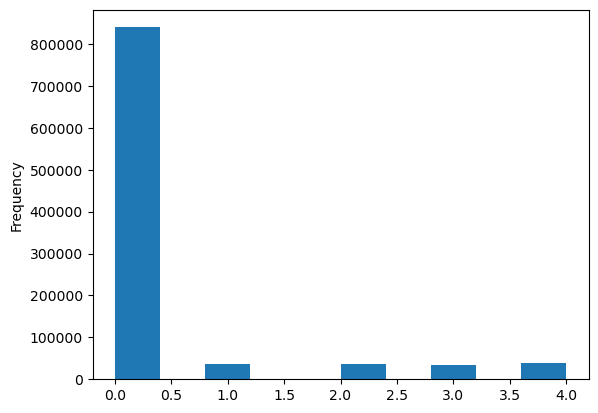

In [56]:
discretised_int['vaso_input'].plot.hist()

<Axes: ylabel='Frequency'>

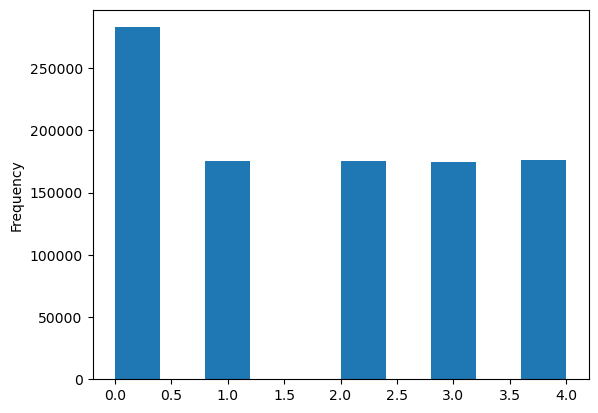

In [57]:
discretised_int['iv_input'].plot.hist()

In [58]:
disc_inp_data = copy.deepcopy(orig_data)

In [59]:
disc_inp_data['vaso_input'] = discretised_int['vaso_input']
disc_inp_data['iv_input'] = discretised_int['iv_input']

In [60]:
disc_inp_data.head()

,Admn001_ID,bloc,Unnamed: 0,Vitl009_SOFA,Flud002_Input4H,Flud003_MaxVaso,OutC002_90d mortality,timeday,SpO2,Temp_C,...,Flud007_rrt_1,Vent001_Mech_0,Vent001_Mech_1,Vitl010_SIRS_1,Vitl010_SIRS_2,Vitl010_SIRS_3,Vitl010_SIRS_4,Vitl010_SIRS_5,vaso_input,iv_input
0,3,1,0,0,20.0,0.0,1.0,19,2,0,...,0,0,1,0,1,0,0,0,0.0,2.0
1,3,2,1,1,20.0,0.0,1.0,20,1,0,...,0,0,1,0,1,0,0,0,0.0,2.0
2,3,3,2,1,20.0,0.0,1.0,21,1,0,...,0,0,1,0,1,0,0,0,0.0,2.0
3,3,4,3,0,20.0,0.0,1.0,22,2,0,...,0,0,1,0,1,0,0,0,0.0,2.0
4,3,5,4,0,20.0,0.0,1.0,23,2,1,...,0,0,1,0,1,0,0,0,0.0,2.0


In [61]:
disc_inp_data['vaso_input'].value_counts()

0.0    840048
4.0     37998
1.0     35945
2.0     35875
3.0     34403
Name: vaso_input, dtype: int64

In [62]:
disc_inp_data['iv_input'].value_counts()

0.0    282790
4.0    176321
2.0    175408
1.0    175331
3.0    174419
Name: iv_input, dtype: int64

In [63]:
disc_inp_data.to_csv('C:/Users/logik/Desktop/rlsepsis234-master - full/data/A002_MyData.csv', index=False)